<a href="https://colab.research.google.com/github/christopherfr/trabajofinalml/blob/main/Trabajo_final_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importamos el dataset

In [ ]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.3.0
Keras Version: 2.4.0

Python 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
Pandas 1.2.0
Scikit-Learn 0.24.0
GPU is available


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16863803793581990106,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4679811648106609413
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3134364059
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18164009592601862952
 physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10450704976474782874
 physical_device_desc: "device: XLA_GPU device"]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_validate
from pprint import pprint

data = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls', header = 1)
data.drop('ID', axis = 1, inplace = True) # Nos deshacemos de la columna ID ya que no es importante
data.rename(columns = {'default payment next month': 'DEFAULT'}, inplace = True) # Nombre cambiado a uno más corto
data.rename(columns = {'PAY_0': 'PAY_1'}, inplace = True) # Corrección del nombre

In [ ]:
data.head(10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,50000,1,1,2,37,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,500000,1,1,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,100000,2,2,2,23,0,-1,-1,0,0,-1,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0
8,140000,2,3,1,28,0,0,2,0,0,0,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,20000,1,3,2,35,-2,-2,-2,-2,-1,-1,0,0,0,0,13007,13912,0,0,0,13007,1122,0,0


## Información acerca del dataset

Lista de variables por tipo

In [ ]:
print('Variables categóricas nominales:')
print('  - SEX\n  - MARRIAGE')
print('Variables categóricas ordinales:')
print('  - EDUCATION')
print('Variables continuas:')
print('  - AGE\n  - PAY_1\n  - PAY_2\n  - PAY_3\n  - PAY_4\n  - PAY_5\n  - PAY_6\n  - BILL_AMT1\n  - BILL_AMT2\n  - BILL_AMT3\n  - BILL_AMT4\n  - BILL_AMT5\n  - BILL_AMT6\n  - PAY_AMT1\n  - PAY_AMT2\n  - PAY_AMT3\n  - PAY_AMT4\n  - PAY_AMT5\n  - PAY_AMT6')
print('Tenemos {} variables independientes en total.'.format(data.shape[1] - 1))
print('Variable target: DEFAULT')

Variables categóricas nominales:
  - SEX
  - MARRIAGE
Variables categóricas ordinales:
  - EDUCATION
Variables continuas:
  - AGE
  - PAY_1
  - PAY_2
  - PAY_3
  - PAY_4
  - PAY_5
  - PAY_6
  - BILL_AMT1
  - BILL_AMT2
  - BILL_AMT3
  - BILL_AMT4
  - BILL_AMT5
  - BILL_AMT6
  - PAY_AMT1
  - PAY_AMT2
  - PAY_AMT3
  - PAY_AMT4
  - PAY_AMT5
  - PAY_AMT6
Tenemos 23 variables independientes en total.
Variable target: DEFAULT


Número de muestras que se usarán en los conjuntos de entrenamiento y prueba, como también la cantidad por cada clase.

In [ ]:
m = len(data)
ratio_test = 0.1
q_test = int(round(m * ratio_test, 0))
q_train = m - q_test
print('Se tienen {} muestras en total. Un {}% se usará para la evaluación, es decir,\nse entrenarán los modelos con {} registros y con {} se evaluarán.'.format(m, ratio_test * 100, q_train, q_test))

import numpy as np
target_agrupado = data.groupby('DEFAULT')['DEFAULT'].count()
q_clases_target = np.array(target_agrupado.sort_index(ascending = True))
p_clases_target = q_clases_target / np.sum(q_clases_target) * 100
print('Para el entrenamiento un {}% será de la clase 0 (no default) y el otro {}% de la clase 1 (default).'.format(round(p_clases_target[0],1), round(p_clases_target[1],1)))

Se tienen 30000 muestras en total. Un 10.0% se usará para la evaluación, es decir,
se entrenarán los modelos con 27000 registros y con 3000 se evaluarán.
Para el entrenamiento un 77.9% será de la clase 0 (no default) y el otro 22.1% de la clase 1 (default).


## Estadística descriptiva y visualización de los datos

### Descripción de las variables

En la siguiente tabla se muestran medidas estadísticas de las variables cuantitativas de la base de datos.

In [ ]:
data.drop(['SEX','EDUCATION','MARRIAGE','DEFAULT'], axis = 1).describe()

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,129747.661567,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,1000000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


### Valores Atípicos

Para analizar los valores atípicos utilizamos el diagrama de cajas. Cabe precisar que los valores atípicos son aquellos que son mayores al bigote superior o menor al bigote inferior del diagrama de cajas

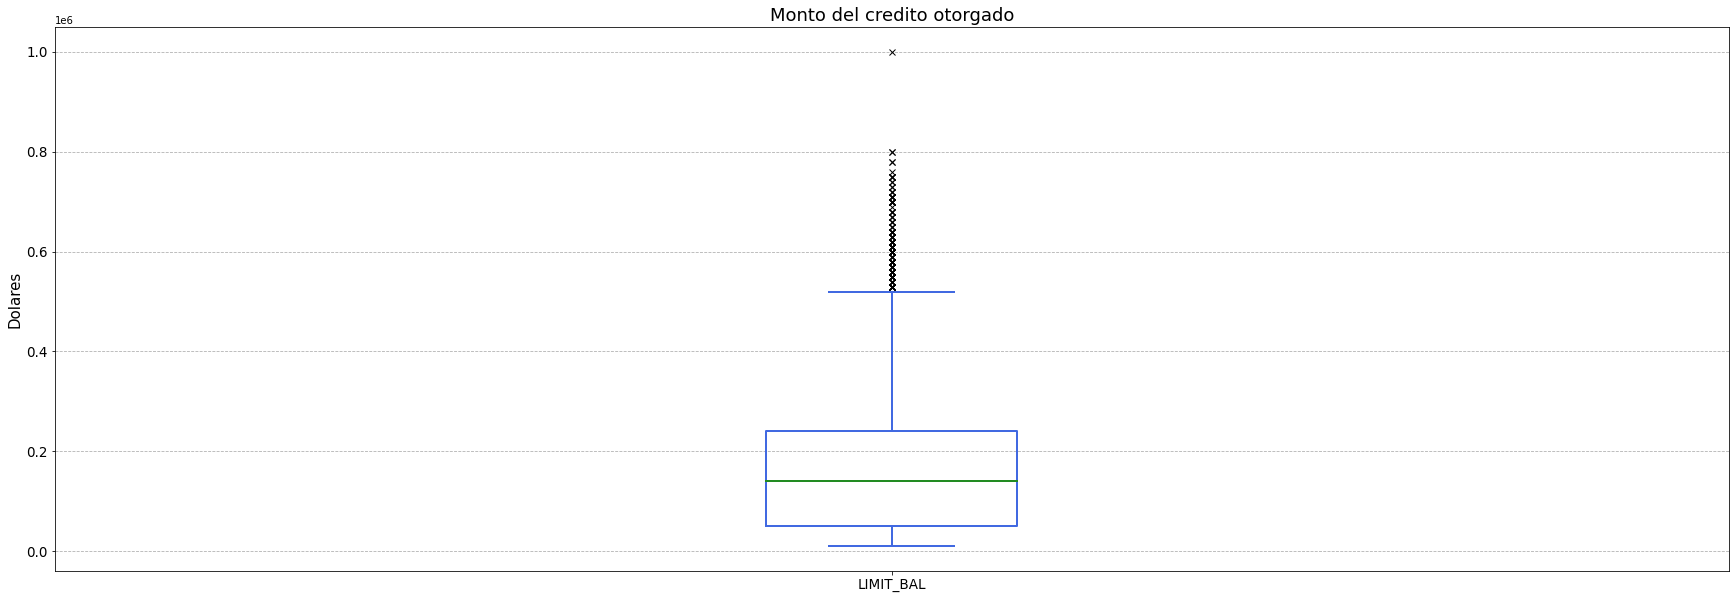

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,1, figsize = (30,10)) # creacion de figuras y
bp3 = data.iloc[:,0:1].boxplot(boxprops = dict(color = 'royalblue', linewidth = 2),
                             medianprops = dict(color = 'forestgreen', linewidth = 2),
                             whiskerprops = dict(color = 'royalblue', linewidth = 2),
                             capprops = dict(color = 'royalblue', linewidth = 2),
                             flierprops = dict(marker = 'x'),
                             grid = False)
bp3.set_title('Monto del credito otorgado', fontsize = 18)
bp3.set_ylabel('Dolares', fontsize = 15)
bp3.tick_params(axis='both', labelsize=13.5)
bp3.grid(axis='y', linestyle='--')

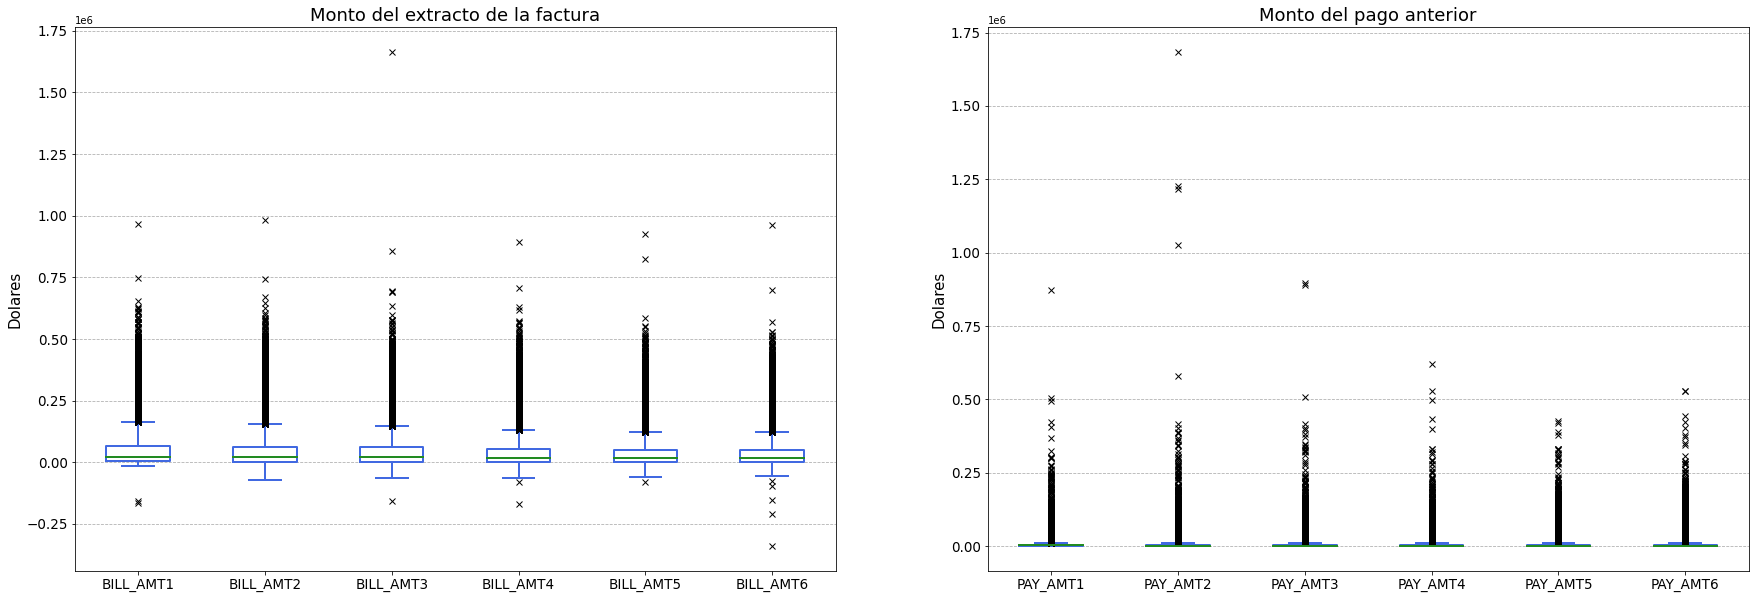

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (30,10)) # create figure and axes
bp1 = data.iloc[:,11:17].boxplot(boxprops = dict(color = 'royalblue', linewidth = 2),
                             medianprops = dict(color = 'forestgreen', linewidth = 2),
                             whiskerprops = dict(color = 'royalblue', linewidth = 2),
                             capprops = dict(color = 'royalblue', linewidth = 2),
                             flierprops = dict(marker = 'x'),
                             grid = False,
                             ax = axes.flatten()[0])
bp1.set_title('Monto del extracto de la factura', fontsize = 18)
bp1.set_ylabel('Dolares', fontsize = 15)
bp1.tick_params(axis='both', labelsize=13.5)
bp1.grid(axis='y', linestyle='--')

bp2 = data.iloc[:,17:23].boxplot(boxprops = dict(color = 'royalblue', linewidth = 2),
                             medianprops = dict(color = 'forestgreen', linewidth = 2),
                             whiskerprops = dict(color = 'royalblue', linewidth = 2),
                             capprops = dict(color = 'royalblue', linewidth = 2),
                             flierprops = dict(marker = 'x'),
                             grid = False,
                             ax = axes.flatten()[1])
bp2.set_title('Monto del pago anterior', fontsize = 18)
bp2.set_ylabel('Dolares', fontsize = 15)
bp2.tick_params(axis='both', labelsize=13.5)
bp2.grid(axis='y', linestyle='--')

Para hallar el bogote superior e inferior es necesario primero hallar el rango intercuartico que esta dado por:

In [ ]:
def IQR(dist):
       return np.percentile(dist, 75) - np.percentile(dist, 25)

Calcular la cantidad de valores atipicos por columnas de :

PAY_AMT1

In [ ]:
p_m1=np.percentile(IQR(data['PAY_AMT1']), 75) + 1.5*IQR(data['PAY_AMT1'])
mayor=data['PAY_AMT1']>p_m1
data[mayor].shape[0]

3187

Se calcula para las columnas PAY_AMT1,PAY_AMT2, PAY_AMT3, PAY_AMT4, PAY_AMT5 , PAY_AMT6 

In [ ]:
lis=[]
i=0
pay_lis={'PAY_AMT1':0 ,'PAY_AMT2':0 ,'PAY_AMT3':0 ,'PAY_AMT4': 0,'PAY_AMT5':0 ,'PAY_AMT6':0  }
for n in range(17,23):
  p_m=np.percentile(IQR(data.iloc[:,n]), 75) + 1.5*IQR(data.iloc[:,n])
  mayor=data.iloc[:,n]>p_m
  tam=data[mayor].shape[0]
  lis.append(tam)

for m in pay_lis:
  pay_lis[m]+=lis[i]
  i+=1
pay_lis


{'PAY_AMT1': 3187,
 'PAY_AMT2': 2997,
 'PAY_AMT3': 2701,
 'PAY_AMT4': 3070,
 'PAY_AMT5': 3020,
 'PAY_AMT6': 2977}

Como se puede observar existen valores atipicos en las columnas correspondientes al monto del pago anterior

### Descripción de la variable Edad

Se muestra un histograma que muestra la distribución de la población con respecto la variable `AGE` (edad).

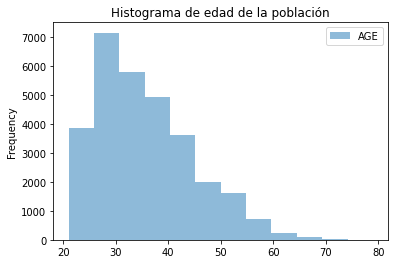

In [ ]:
data.AGE.plot.hist(bins = 12, alpha=0.5)
plt.title('Histograma de edad de la población')
plt.legend()
plt.show()

Para las variables categóricas mostramos la cantidad de registros por cada categoría y el porcentaje que representan del total

Descripción de la variable Sexo

Se muestra una grafica de barras que muestra la distribucion de la población respecto a la variable `SEX` (sexo), donde:
*   1 = Male
*   2 = Female

In [ ]:
enc = {1:'male', 2:'female'}
c = data.SEX.replace(enc).value_counts()
p = data.SEX.replace(enc).value_counts(normalize = True) * 100
pd.concat([c,p], axis=1, keys=['# registros', '% del total'])

,# registros,% del total
female,18112,60.373333
male,11888,39.626667


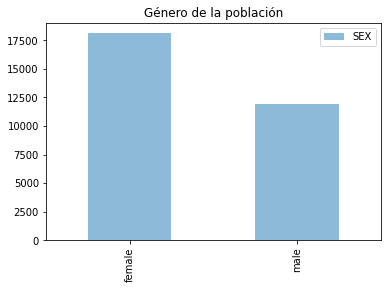

In [ ]:
data.SEX.replace(enc).value_counts().plot(kind='bar',alpha=0.5)
plt.title('Género de la población')
plt.legend()
plt.show()

### Descripción de la variable Educación

Se muestra una grafica de barras que muestra la distribucion de la población respecto a la variable `EDUCATION` (nivel educativo), donde:

*   1 = graduate school
*   2 = university
*   3 = high school
*   4 = others


In [ ]:
enc = {1:'graduate school', 2:'university', 3:'high school', 4:'others', 5:'others', 6:'others', 0:'others'}
c = data.EDUCATION.replace(enc).value_counts()
p = data.EDUCATION.replace(enc).value_counts(normalize = True) * 100
pd.concat([c,p], axis=1, keys=['# registros', '% del total'])

,# registros,% del total
university,14030,46.766667
graduate school,10585,35.283333
high school,4917,16.390000
others,468,1.560000


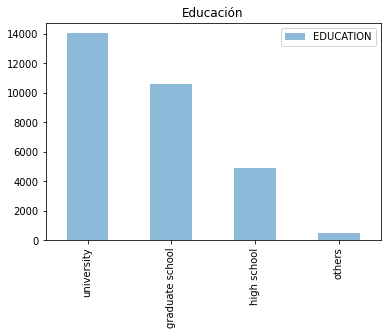

In [ ]:
data.EDUCATION.replace(enc).value_counts().plot(kind = 'bar',alpha=0.5)
plt.title('Educación')
plt.legend()
plt.show()

### Descripción de la variable Marriage

Se muestra una grafica de barras que muestra la distribucion de la población respecto a la variable `MARRIAGE` (estado civil), donde:
*   1 = married
*   2 = single
*   3 = others


In [ ]:
enc = {1:'married', 2:'single', 3:'others', 0:'others'}
c = data.MARRIAGE.replace(enc).value_counts()
p = data.MARRIAGE.replace(enc).value_counts(normalize = True) * 100
pd.concat([c,p], axis=1, keys=['# registros', '% del total'])

,# registros,% del total
single,15964,53.213333
married,13659,45.530000
others,377,1.256667


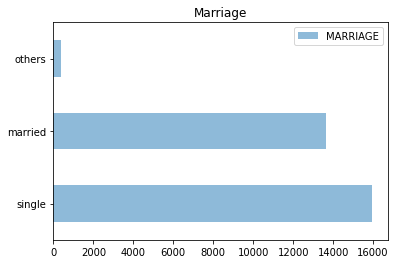

In [ ]:
data.MARRIAGE.replace(enc).value_counts().plot(kind='barh',alpha=0.5)
plt.title('Marriage')
plt.legend()
plt.show()

## Modelamiento

### Preprocesamiento de la data

[De acuerdo al autor del dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset/discussion/34608), en el caso de la variable `EDUCATION` se debe considerar a los valores 0, 4, 5 y 6 como de la clase `others`.

In [ ]:
enc = {4:0, 5:0, 6:0}
data.EDUCATION.replace(enc, inplace = True)

De igual manera para la variable `MARRIAGE` a los valores 0 y 3.

In [ ]:
enc = {3:0}
data.MARRIAGE.replace(enc, inplace = True)

También creamos variables dummy para las categóricas



In [ ]:
data = pd.get_dummies(data, columns = ['SEX','MARRIAGE'], drop_first = True)

In [ ]:
data

,LIMIT_BAL,EDUCATION,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,SEX_2,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,20000,2,24,2,2,-1,-1,-2,-2,3913,...,689,0,0,0,0,1,1,1,0,0
1,120000,2,26,-1,2,0,0,0,2,2682,...,1000,1000,1000,0,2000,1,1,0,1,0
2,90000,2,34,0,0,0,0,0,0,29239,...,1500,1000,1000,1000,5000,0,1,0,1,0
3,50000,2,37,0,0,0,0,0,0,46990,...,2019,1200,1100,1069,1000,0,1,1,0,0
4,50000,2,57,-1,0,-1,0,0,0,8617,...,36681,10000,9000,689,679,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,3,39,0,0,0,0,0,0,188948,...,20000,5003,3047,5000,1000,0,0,1,0,0
29996,150000,3,43,-1,-1,-1,-1,0,0,1683,...,3526,8998,129,0,0,0,0,0,1,0
29997,30000,2,37,4,3,2,-1,0,0,3565,...,0,22000,4200,2000,3100,1,0,0,1,0
29998,80000,3,41,1,-1,0,0,0,-1,-1645,...,3409,1178,1926,52964,1804,1,0,1,0,0


In [ ]:
or1=data.iloc[:, :21]
or2=data.iloc[:,-4:]
or3=data['DEFAULT']
data = pd.concat([or1,or2,or3], axis=1,)
data

,LIMIT_BAL,EDUCATION,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_2,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,DEFAULT
0,20000,2,24,2,2,-1,-1,-2,-2,3913,...,689,0,0,0,0,1,1,0,0,1
1,120000,2,26,-1,2,0,0,0,2,2682,...,1000,1000,1000,0,2000,1,0,1,0,1
2,90000,2,34,0,0,0,0,0,0,29239,...,1500,1000,1000,1000,5000,1,0,1,0,0
3,50000,2,37,0,0,0,0,0,0,46990,...,2019,1200,1100,1069,1000,1,1,0,0,0
4,50000,2,57,-1,0,-1,0,0,0,8617,...,36681,10000,9000,689,679,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,3,39,0,0,0,0,0,0,188948,...,20000,5003,3047,5000,1000,0,1,0,0,0
29996,150000,3,43,-1,-1,-1,-1,0,0,1683,...,3526,8998,129,0,0,0,0,1,0,0
29997,30000,2,37,4,3,2,-1,0,0,3565,...,0,22000,4200,2000,3100,0,0,1,0,1
29998,80000,3,41,1,-1,0,0,0,-1,-1645,...,3409,1178,1926,52964,1804,0,1,0,0,1


Separamos entre train y test. La separación se ha realizado en un 20% para test y el 80% restante para train.

In [ ]:
from sklearn.model_selection import train_test_split

X = data.drop('DEFAULT', axis = 1)
y = data['DEFAULT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Proporción de la variable a predecir para ambas particiones 

Train

In [ ]:
enc = {0:'NO DEFAULT', 1:'DEFAULT'}
a= y_train.replace(enc).value_counts()
b= y_train.replace(enc).value_counts(normalize=True)*100
pd.concat([a,b], axis=1, keys=['# registros', '% del total'])

,# registros,% del total
NO DEFAULT,18689,77.870833
DEFAULT,5311,22.129167


Test

In [ ]:
enc = {0:'NO DEFAULT', 1:'DEFAULT'}
c= y_test.replace(enc).value_counts()
d= y_test.replace(enc).value_counts(normalize=True)*100
pd.concat([c,d], axis=1, keys=['# registros', '% del total'])

,# registros,% del total
NO DEFAULT,4675,77.916667
DEFAULT,1325,22.083333


La proporción de los dos grupos de la variable a predecir es muy similar en ambas particiones.

### Algoritmo Random Forests

El primer clasificador que entrenamos es el Random Forests. A continuación creamos una nueva instancia de este clasificador y mostramos su performance con los hiperparámetros con valores por defecto. 

In [ ]:
nombre_gpu = tf.test.gpu_device_name()
if nombre_gpu != '/device:GPU:0':
  raise SystemError('GPU no encontrada')
print('GPU encontrada: {}'.format(nombre_gpu))

GPU encontrada: /device:GPU:0


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

d_rfc = RandomForestClassifier(n_jobs = -1)
skf = StratifiedKFold(n_splits = 10)
with tf.device('/device:GPU:0'):
    d_rfc_res = cross_validate(d_rfc, X_train, y_train, cv = skf, return_train_score = True, scoring = ['accuracy','f1','roc_auc'], n_jobs = -1)
print('Los valores por defecto de los hiperparámetros del algoritmo RF son:')
d_rfc.get_params()

Los valores por defecto de los hiperparámetros del algoritmo RF son:


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Y obtuvimos los siguientes resultados del área bajo la curva ROC:

In [ ]:
print('El área bajo la curva ROC promedio en el conjunto de train de la validación cruzada fue de {}'.format(np.mean(d_rfc_res['train_roc_auc'])))
print('El área bajo la curva ROC promedio en el conjunto de test de la validación cruzada fue de {}'.format(np.mean(d_rfc_res['test_roc_auc'])))

El área bajo la curva ROC promedio en el conjunto de train de la validación cruzada fue de 0.9999975895153751
El área bajo la curva ROC promedio en el conjunto de test de la validación cruzada fue de 0.7623077498012398


Notamos que obtuvimos un valor muy alto con el conjunto de entrenamiento, pero en la evaluación salió muy bajo, esto es un claro indicador de que el modelo tiene un sesgo muy alto (overfitting). 

Antes de empezar la búsqueda aleatoria de los mejores hiperparámetros, revisamos a partir de qué cantidad de árboles la métricas dejan de mejorar, con ese valor fijamos a `n_estimators` y ahorramos tiempo de procesamiento.

In [ ]:
lista_q_arboles = np.around(np.linspace(2, 500, 10, endpoint = True)).astype(int)

train_accuracy = []
test_accuracy = []
train_f1 = []
test_f1 = []
train_roc_auc = []
test_roc_auc = []
with tf.device('/device:GPU:0'):
    for q_arboles in lista_q_arboles:
        i_rfc = RandomForestClassifier(n_estimators = q_arboles, random_state = 42, n_jobs = -1)
        i_rfc_res = cross_validate(i_rfc, X, y, cv = skf, return_train_score = True, scoring = ['accuracy','f1','roc_auc'], n_jobs = -1)
        train_accuracy.append(np.mean(i_rfc_res['train_accuracy']))
        test_accuracy.append(np.mean(i_rfc_res['test_accuracy']))
        train_f1.append(np.mean(i_rfc_res['train_f1'])) 
        test_f1.append(np.mean(i_rfc_res['test_f1']))
        train_roc_auc.append(np.mean(i_rfc_res['train_roc_auc'])) 
        test_roc_auc.append(np.mean(i_rfc_res['test_roc_auc']))

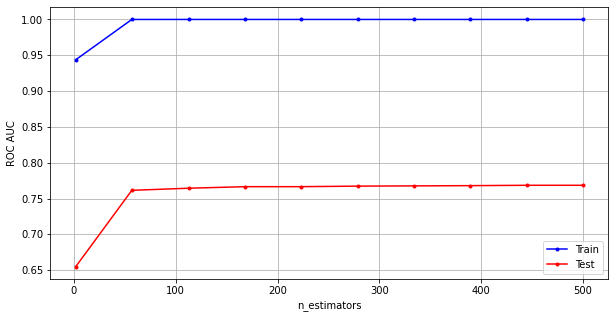

Notamos en la gráfica que a partir de los 70 árboles la métrica ya no se incrementa tanto. Usaremos 70 para el valor de n_estimators.


In [ ]:
import matplotlib.pyplot as plt

plt.figure(num = 1, figsize = (10,5))
plt.plot(lista_q_arboles, train_roc_auc, 'b', marker = '.', label = 'Train')
plt.plot(lista_q_arboles, test_roc_auc, 'r', marker = '.', label = 'Test')
plt.ylabel('ROC AUC')
plt.xlabel('n_estimators')
plt.legend(loc = 'lower right')
plt.grid()
plt.show()

#plt.figure(num = 2, figsize = (10,5))
#plt.plot(lista_q_arboles, train_roc_auc, 'b', marker = '.', label = 'Train')
#plt.plot(lista_q_arboles, test_roc_auc, 'r', marker = '.', label = 'Test')
#plt.ylabel('Accuracy')
#plt.xlabel('n_estimators')
#plt.legend(loc = 'lower right')
#plt.grid()
#plt.show()

print('Notamos en la gráfica que a partir de los 70 árboles la métrica ya no se incrementa tanto. Usaremos 70 para el valor de n_estimators.')

Con esto en mente, realizamos una primera búsqueda en grilla para encontrar a los hiperparámetros que generen al mejor modelo.

In [ ]:
from pprint import pprint

max_features = ['auto', 8, 10, 12, None]  # 'auto' equivale a 'sqrt'; None equivale a todas
max_depth = [int(x) for x in np.linspace(5, 20, num = 4)]
min_samples_leaf = [2, 4, 6]

rf_grid1_hp = {'max_features': max_features,
             'max_depth': max_depth,
             'min_samples_leaf': min_samples_leaf}

print('Los valores a probar en la primera búsqueda en grilla son:')
pprint(rf_grid1_hp)

print('\nSe entrenarán', 
      len(rf_grid1_hp['max_features']) *
      len(rf_grid1_hp['max_depth']) *
      len(rf_grid1_hp['min_samples_leaf']),
      'modelos.')

Los valores a probar en la primera búsqueda en grilla son:
{'max_depth': [5, 10, 15, 20],
 'max_features': ['auto', 8, 10, 12, None],
 'min_samples_leaf': [2, 4, 6]}

Se entrenarán 60 modelos.


In [ ]:
from sklearn.model_selection import GridSearchCV

with tf.device('/device:GPU:0'):
    rf = RandomForestClassifier(n_estimators = 70) # n_estimators va a ser el único hiperparámetro fijo
    rf_grid1 = GridSearchCV(estimator = rf, 
                               param_grid = rf_grid1_hp,
                               cv = skf,          # Validación cruzada 10-fold
                               scoring = ['accuracy','f1','roc_auc'],
                               refit = 'roc_auc',
                               return_train_score = True,
                               verbose = 2, 
                               n_jobs = -1)      # Paralelizar en todos los cores disponibles

    rf_grid1.fit(X_train, y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 47.1min finished


En la siguiente tabla podemos ver los 5 modelos con las mejores métricas producto de la primera búsqueda en grilla.

In [ ]:
pd.DataFrame(rf_grid1.cv_results_)[['rank_test_roc_auc','param_max_depth','param_max_features','param_min_samples_leaf','mean_train_roc_auc','mean_test_roc_auc']].sort_values('rank_test_roc_auc').head(5)

,rank_test_roc_auc,param_max_depth,param_max_features,param_min_samples_leaf,mean_train_roc_auc,mean_test_roc_auc
20,1,10,8,6,0.854084,0.781343
26,2,10,12,6,0.857579,0.780955
17,3,10,auto,6,0.848149,0.780655
24,4,10,12,2,0.865451,0.780277
28,5,10,None,4,0.863318,0.780204


In [ ]:
rf_grid1_best = rf_grid1.best_estimator_

print('Los hiperparámetros del mejor modelo son:')
print(rf_grid1.best_params_)

print('\nLa mayor área bajo la curva ROC luego de la primera búsqueda en grilla en entrenamiento (80% dataset) es:', rf_grid1_best.score(X_train, y_train))
print('La mayor área bajo la curva ROC luego de la primera búsqueda en grilla en validación (20% dataset) es:', rf_grid1_best.score(X_test, y_test))

Los hiperparámetros del mejor modelo son:
{'max_depth': 10, 'max_features': 8, 'min_samples_leaf': 6}

La mayor área bajo la curva ROC luego de la primera búsqueda en grilla en entrenamiento (80% dataset) es: 0.8500416666666667
La mayor área bajo la curva ROC luego de la primera búsqueda en grilla en validación (20% dataset) es: 0.823


Ahora buscaremos con mayor precisión los mejores hiperparámetros es una segunda búsqueda en grilla focalizada.

In [ ]:
max_features = [8,9,10,11,12,13]
max_depth = [5, 10, 15]
min_samples_leaf = [3,4,5,6]

rf_grid2_hp = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}

print('Los valores a probar en la segunda búsqueda por grilla son:')
pprint(rf_grid2_hp)

Los valores a probar en la segunda búsqueda por grilla son:
{'max_depth': [5, 10, 15],
 'max_features': [8, 9, 10, 11, 12, 13],
 'min_samples_leaf': [3, 4, 5, 6]}


In [ ]:
from sklearn.model_selection import GridSearchCV

with tf.device('/device:GPU:0'):
    rf = RandomForestClassifier(n_estimators = 70)
    rf_grid2 = GridSearchCV(estimator = rf, 
                        param_grid = rf_grid2_hp, 
                        cv = skf,          # Validación cruzada 10-fold
                        scoring = ['accuracy','f1','roc_auc'],
                        refit = 'roc_auc',
                        return_train_score = True,
                        verbose = 2, 
                        n_jobs = -1)      # Paralelizar en todos los cores disponibles
    rf_grid2.fit(X_train, y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 37.6min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 45.3min finished


In [ ]:
pd.DataFrame(rf_grid2.cv_results_)[['rank_test_roc_auc','param_max_depth','param_max_features','param_min_samples_leaf','mean_train_roc_auc','mean_test_roc_auc']].sort_values('rank_test_roc_auc').head(5)

,rank_test_roc_auc,param_max_depth,param_max_features,param_min_samples_leaf,mean_train_roc_auc,mean_test_roc_auc
38,1,10,11,5,0.859382,0.781280
35,2,10,10,6,0.856110,0.780949
37,3,10,11,4,0.860812,0.780938
34,4,10,10,5,0.858123,0.780655
30,5,10,9,5,0.856908,0.780620


In [ ]:
rf_grid2_best = rf_grid2.best_estimator_

print('Los hiperparámetros del mejor modelo son:')
pprint(rf_grid2.best_params_)
print()

print('El área bajo la curva ROC luego de búsqueda en grilla en entrenamiento:', rf_grid2_best.score(X_train, y_train))
print('El área bajo la curva ROC luego de búsqueda en grilla en validación:', rf_grid2_best.score(X_test, y_test))

Los hiperparámetros del mejor modelo son:
{'max_depth': 10, 'max_features': 11, 'min_samples_leaf': 5}

El área bajo la curva ROC luego de búsqueda en grilla en entrenamiento: 0.8515833333333334
El área bajo la curva ROC luego de búsqueda en grilla en validación: 0.8243333333333334


A continuación, se muestra la Curva ROC. La curva ROC es una mejor metrica para ver que tan bueno es el clasificador sobre todo cuando existe un desbalanceo en las clases. Para estos casos es una mejor medida que el accuracy.

AUC = 0.7789734234688731


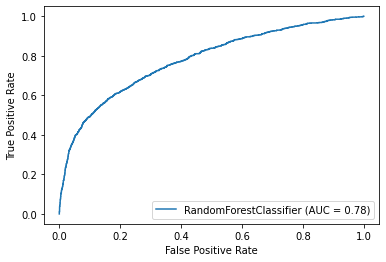

In [ ]:
from sklearn.metrics import roc_auc_score, plot_roc_curve

y_pred_val = rf_grid2_best.predict_proba(X_test)[:,1]
auc_roc = roc_auc_score(y_test, y_pred_val)
print('AUC =', auc_roc)

plot_roc_curve(rf_grid2_best, X_test, y_test)
plt.show()                 

#### GANANCIA DE LA INFORMACIÓN

In [ ]:
instancias= data.shape[0]
columnas= data.shape[1]
print(instancias)
print(columnas)

30000
26


Función logaritmo

In [ ]:
import math

def log2(p):
  return math.log2(p)

Definir funcion de la entropia

In [ ]:
def calcular_entropia_def(df, instancias_in):
  entropia = 0
  clases = df['DEFAULT'].value_counts().keys().tolist()
  for i in range(0, len(clases)):
    prob = df.iloc[:, -1].value_counts().tolist()[i]/instancias_in
    entropia += -prob*log2(prob)
  return entropia  

Entropia

In [ ]:
entropia_def=calcular_entropia_def(data, instancias)
entropia_def

0.7623526222941667

Función ganancia de la información

In [ ]:
import operator
def entropia_clases_def(df):
  ganancias = []
  dict_gan={}
  for i in range(0, columnas-1):
    nombre_atributo = df.columns[i]
    clases_atributo = df[nombre_atributo].value_counts()
    ganancia = entropia_def

    for j in range(0, len(clases_atributo)):
      clase_actual = clases_atributo.keys().tolist()[j]
      subdata = df[df[nombre_atributo]==clase_actual]
      subdata_instancias = subdata.shape[0]
      subdata_entropia = calcular_entropia_def(subdata, subdata_instancias)
      clase_a_probabilidad = subdata_instancias/instancias
      ganancia = ganancia - clase_a_probabilidad*subdata_entropia
      ganancia= round(ganancia,5)
    ganancias.append(ganancia)
  # crea diccionario de cada atributo con su ganancia
  for i in range(0, columnas-1):
    nombre_atributo = df.columns[i]
    gan= ganancias[i]
    dict_gan[nombre_atributo]=gan
  ganancia_mayor = ganancias.index(max(ganancias))
  nombre_mejor_ganancia = df.columns[ganancia_mayor]
  ord_dic=sorted(dict_gan.items(), key=operator.itemgetter(1), reverse=True)
  return ord_dic

In [ ]:
entropia_def= calcular_entropia_def(data, instancias)
print("entropia_default: ", entropia_def)

nombre_mejor_def = entropia_clases_def(data) # error: list index out of range, 
#se muestra el diccioonario con los atributos y sus ganancias 
print(nombre_mejor_def)

entropia_default:  0.7623526222941667
[('BILL_AMT1', 0.58125), ('BILL_AMT2', 0.57227), ('BILL_AMT3', 0.565), ('BILL_AMT4', 0.55385), ('BILL_AMT5', 0.5404), ('BILL_AMT6', 0.52949), ('PAY_AMT1', 0.2024), ('PAY_AMT2', 0.19192), ('PAY_AMT3', 0.18894), ('PAY_AMT6', 0.17433), ('PAY_AMT4', 0.17368), ('PAY_AMT5', 0.17157), ('PAY_1', 0.10972), ('PAY_2', 0.07077), ('PAY_3', 0.05378), ('PAY_4', 0.04744), ('PAY_5', 0.04407), ('PAY_6', 0.03811), ('LIMIT_BAL', 0.02433), ('EDUCATION', 0.00443), ('AGE', 0.00374), ('SEX_2', 0.00114), ('MARRIAGE_2', 0.00068), ('MARRIAGE_1', 0.00064), ('MARRIAGE_3', 7e-05)]


Se forma un dataset solo con las variables que tengan mayor ganancia de la información

In [ ]:
X2=data.iloc[:,9:21]
y=data['DEFAULT']
X2

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,3913,3102,689,0,0,0,0,689,0,0,0,0
1,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000
29996,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0
29997,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100
29998,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804


Realizar la partición

In [ ]:
X2_train,X2_test,y2_train,y2_test=train_test_split(X2,y,test_size = 0.2)

In [ ]:
from pprint import pprint
max_features = ['auto', 8, 10, 12, None]  # 'auto' equivale a 'sqrt'; None equivale a todas
max_depth = [int(x) for x in np.linspace(5, 20, num = 4)]
min_samples_leaf = [2, 4, 6]

rf_grid3_hp = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}

print('Los valores a probar en la segunda búsqueda por grilla son:')
pprint(rf_grid3_hp)

Los valores a probar en la segunda búsqueda por grilla son:
{'max_depth': [5, 10, 15, 20],
 'max_features': ['auto', 8, 10, 12, None],
 'min_samples_leaf': [2, 4, 6]}


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

skf = StratifiedKFold(n_splits = 10)
with tf.device('/device:GPU:0'):
    rf = RandomForestClassifier(n_estimators = 500,criterion='entropy')
    rf_grid3 = GridSearchCV(estimator = rf, 
                        param_grid = rf_grid3_hp, 
                        cv = skf,          # Validación cruzada 10-fold
                        scoring = ['accuracy','f1','roc_auc'],
                        refit = 'roc_auc',
                        return_train_score = True,
                        verbose = 2, 
                        n_jobs = -1)      # Paralelizar en todos los cores disponibles
    rf_grid3.fit(X2_train, y2_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


In [ ]:
rf_grid3_best = rf_grid3.best_estimator_

print('Los hiperparámetros del mejor modelo son:')
pprint(rf_grid3.best_params_)
print()

print('El área bajo la curva ROC luego de búsqueda en grilla en entrenamiento:', rf_grid3_best.score(X2_train, y2_train))
print('El área bajo la curva ROC luego de búsqueda en grilla en validación:', rf_grid3_best.score(X2_test, y2_test))

Los hiperparámetros del mejor modelo son:
{'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 6}

El área bajo la curva ROC luego de búsqueda en grilla en entrenamiento: 0.8169166666666666
El área bajo la curva ROC luego de búsqueda en grilla en validación: 0.8015


AUC = 0.7279553030982083


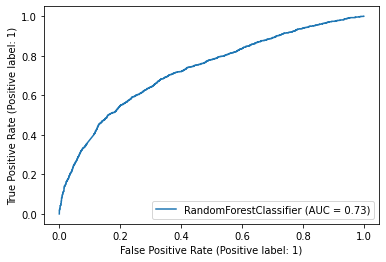

In [ ]:
from sklearn.metrics import roc_auc_score, plot_roc_curve
y_pred_val2 = rf_grid3_best.predict_proba(X2_test)[:,1]
auc_roc = roc_auc_score(y2_test, y_pred_val2)
print('AUC =', auc_roc)

plot_roc_curve(rf_grid3_best, X2_test, y2_test)
plt.show() 

### K Nearest Neighbours

Como paso previo al entrenamiento del algoritmo, necesitamos normalizar la data, ya que KNN utiliza las distancias entre las observaciones para calcular la cercanía y en base a eso, clasificar.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Ahora entrenaremos el algoritmo con los hiperparámetros por defecto para tomar su rendimiento como base.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

d_knn = KNeighborsClassifier(n_jobs = -1)
with tf.device('/device:GPU:0'):
    d_knn_res = cross_validate(d_knn, X_train_scaled, y_train, cv = skf, return_train_score = True, scoring = ['accuracy','f1','roc_auc'], verbose = 2, n_jobs = -1)
print('Los valores por defecto de los hiperparámetros del algoritmo kNN son:')
d_knn.get_params()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Los valores por defecto de los hiperparámetros del algoritmo kNN son:


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.6min finished


{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': -1,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Y obtuvimos los siguientes resultados del área bajo la curva ROC:

In [ ]:
print('El área bajo la curva ROC en el conjunto de train fue de {}'.format(np.mean(d_knn_res['train_roc_auc'])))
print('El área bajo la curva ROC en el conjunto de test fue de {}'.format(np.mean(d_knn_res['test_roc_auc'])))

El área bajo la curva ROC en el conjunto de train fue de 0.8798524934076996
El área bajo la curva ROC en el conjunto de test fue de 0.7027308258474603


Tomando este resultado en cuenta. Realizamos una búsqueda en grilla de los hiperparámetros que generan el modelo con las mejores métricas.

In [ ]:
n_neighbors = [int(x) for x in np.linspace(5, 100, 6, endpoint = True)]
weights = ['uniform', 'distance']
p = [1,2]

knn_grid1_hp = {'n_neighbors': n_neighbors,
              'weights': weights,
              'p': p}

print('Los valores a probar en la búsqueda en grilla son:')
pprint(knn_grid1_hp)

print('\nEntrenaremos ', 
      len(knn_grid1_hp['n_neighbors']) *
      len(knn_grid1_hp['weights']) *
      len(knn_grid1_hp['p']),
      'modelos en total.')

Los valores a probar en la búsqueda en grilla son:
{'n_neighbours': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 'p': [1, 2],
 'weights': ['uniform', 'distance']}

Entrenaremos  200 modelos en total.


Entrenaremos  24 modelos en total.

In [ ]:
with tf.device('/device:GPU:0'):
  knn_grid1 = GridSearchCV(estimator = d_knn,
                            param_grid = knn_grid1_hp,
                            cv = skf,
                            scoring = ['accuracy','f1','roc_auc'],
                            refit = 'roc_auc',
                            return_train_score = True,
                            verbose = 2,
                            n_jobs = -1)
  knn_grid1.fit(X_train_scaled, y_train)

In [ ]:
pd.DataFrame(knn_grid1.cv_results_)[['rank_test_roc_auc','param_n_neighbors','param_p','param_weights','mean_train_roc_auc','mean_test_roc_auc']].sort_values('rank_test_roc_auc').head(5)

Según los resultados obtenidos, los modelos entrenados con el hiperparámetro weights igual a 'distance' muestran un alto overfitting y tienen un área bajo la curva ROC menor al de su contraparte con 'uniform'. Por este motivo fijaremos este hiperparámetro en 'uniform'.

In [ ]:
n_neighbors = [int(x) for x in np.linspace(knn_grid1.best_params_['n_neighbors'] - 20, knn_grid1.best_params_['n_neighbors'] + 20, 10, endpoint = True)]
weights = ['uniform']
p = [1,2]

knn_grid2 = {'n_neighbors': n_neighbors,
            'weights': weights,
            'p': p}

print('Los valores a probar en la búsqueda en grilla son:')
pprint(knn_grid2)

print('\nEntrenaremos', 
      len(knn_grid2['n_neighbors']) *
      len(knn_grid2['weights']) *
      len(knn_grid2['p']),
      'modelos en total.')

Ahora realizaremos una segunda búsqueda en grilla focalizada en el número de vecinos n_neighbors

In [ ]:
with tf.device('/device:GPU:0'):
  knn_grid2 = GridSearchCV(estimator = d_knn,
                            param_grid = knn_grid2,
                            cv = skf,
                            scoring = ['accuracy','f1','roc_auc'],
                            refit = 'roc_auc',
                            return_train_score = True,
                            verbose = 2,
                            n_jobs = -1)
  knn_grid2.fit(X_train_scaled, y_train)

In [ ]:

pd.DataFrame(knn_grid2.cv_results_)[['rank_test_roc_auc','param_n_neighbors','param_p','param_weights','mean_train_roc_auc','mean_test_roc_auc']].sort_values('rank_test_roc_auc').head(5)


Usamos el conjunto de datos de validación para conocer el rendimiento de este mejor modelo ante data completamente nueva.

In [ ]:
knn_grid2_best = knn_grid2.best_estimator_

print('Los hiperparámetros del mejor modelo son:')
pprint(knn_grid2.best_params_)
print()

print('El área bajo la curva ROC luego de búsqueda en grilla en entrenamiento (80% dataset):', knn_grid2_best.score(X_train_scaled, y_train))
print('El área bajo la curva ROC luego de búsqueda en grilla en validación (20% dataset):', knn_grid2_best.score(X_test_scaled, y_test))

In [ ]:
knn_grid2_best.predict_proba(X_test_scaled)

In [ ]:
y_pred_val = knn_grid2_best.predict_proba(X_test_scaled)[:,1]
auc_roc = roc_auc_score(y_test, y_pred_val)
print('AUC =', auc_roc)

plot_roc_curve(knn_grid2_best, X_test_scaled, y_test)
plt.show()

### Modelo SVM

Realizaremos también la normalización de los datos.

In [ ]:
from sklearn.svm import SVC
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from time import time
tiempo_inicial = time() 
with tf.device('/device:GPU:0'):
  model_SVC = SVC(kernel='rbf', C=5, gamma=0.001,probability=True)
  model_SVC.fit(X_train_scaled, y_train)

  score_train = model_SVC.score(X_train_scaled, y_train)
  score_test = model_SVC.score(X_test_scaled, y_test)

  print ('Exactitud en el conjunto de entrenamiento: %0.4f' % score_train)
  print ('Exactitud en el conjunto de validación: %0.4f' % score_test)
    
tiempo_final=time()
tiempo=tiempo_final-tiempo_inicial

Exactitud en el conjunto de entrenamiento: 0.8092
Exactitud en el conjunto de validación: 0.8132


AUC = 0.7262471500422689


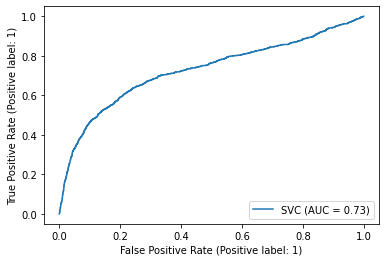

In [ ]:
from sklearn import metrics
y_pred_val_SVC = model_SVC.predict_proba(X_test_scaled)[:,1]
auc_roc = metrics.roc_auc_score(y_test, y_pred_val_SVC)
print('AUC =', auc_roc)

metrics.plot_roc_curve(model_SVC, X_test_scaled, y_test)
plt.show()    

In [ ]:
C=[100]
gamma=[0.001,0.01,0.1,1]
C_param ={ 'C': C,     
              'gamma': gamma  
          }

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV

skf = StratifiedKFold(n_splits = 10)
with tf.device("/device:GPU:0"):
    model_SVC_Grid = SVC(kernel='rbf',probability=True)
    SVC_grid = GridSearchCV(estimator = model_SVC_Grid, 
                      param_grid = C_param, 
                      cv = skf,          # Validación cruzada 10-fold
                      scoring = ['accuracy','f1'],
                      refit = 'f1',
                      verbose=2, 
                      n_jobs = -1)      # Paralelizar en todos los cores disponibles
    SVC_grid.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [ ]:
SVC_grid_best = SVC_grid.best_estimator_
SVC_grid_best

SVC(C=100, gamma=0.01, probability=True)

In [ ]:
from pprint import pprint
print('Los hiperparámetros del mejor modelo son:')
pprint(SVC_grid.best_params_)
print()

print('Exactitud luego de búsqueda en grilla en entrenamiento:', SVC_grid_best.score(X_train_scaled, y_train))
print('Exactitud luego de búsqueda en grilla en validación:', SVC_grid_best.score(X_test_scaled, y_test))

Los hiperparámetros del mejor modelo son:
{'C': 100, 'gamma': 0.01}

Exactitud luego de búsqueda en grilla en entrenamiento: 0.8302083333333333
Exactitud luego de búsqueda en grilla en validación: 0.8205


AUC = 0.7374778391359381


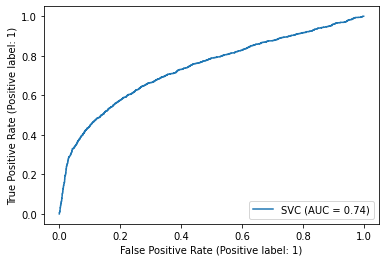

In [ ]:
from sklearn import metrics

y_pred_val_SVC = SVC_grid_best.predict_proba(X_test_scaled)[:,1]
auc_roc = metrics.roc_auc_score(y_test, y_pred_val_SVC)
print('AUC =', auc_roc)

metrics.plot_roc_curve(SVC_grid_best, X_test_scaled, y_test)
plt.show()               

Se obtiene un valor de ROC_AUC=0.74

#### Reducción de dimensionalidad

Utiizamos PCA para reducir la dimensionalidad del dataset, mediante la extracción de caracteristicas 

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Ajuste solo en el set de entrenamiento.
scaler.fit(X_train)
# Aplicar la transformación tanto al conjunto de entrenamiento como al conjunto de prueba. 
Xtrain_scaler_PCA = scaler.transform(X_train)
Xtest_scaler_PCA = scaler.transform(X_test)

Se elige el numero minimo de componentes de forma que conserve el 95% de la varianza

In [ ]:
from sklearn.decomposition import PCA
# Crea una instancia del Modelo 
pca = PCA(.95)

Se ajusta el PCA solo en el conjunto de entrenamiento

In [ ]:
pca.fit (Xtrain_scaler_PCA)

PCA(n_components=0.95)

Para observar la cantidad de componentes que se va a utilizar

In [ ]:
pca.n_components_ 

16

Se realiza la transformacion tanto para el conjunto de entrenamiento como de test

In [ ]:
Xtrain_PCA = pca.transform (Xtrain_scaler_PCA) 
Xtest_PCA = pca.transform (Xtest_scaler_PCA)

Aplicar SVC

In [ ]:
with tf.device('/device:GPU:0'):
    model_SVC = SVC(kernel='rbf', C=10000, gamma=0.01,probability=True)
    model_SVC.fit(Xtrain_PCA, y_train)

    score_train_PCA = model_SVC.score(Xtrain_PCA, y_train)
    score_test_PCA = model_SVC.score(Xtest_PCA, y_test)

    print ('Exactitud en el conjunto de entrenamiento: %0.4f' % score_train_PCA)
    print ('Exactitud en el conjunto de validación: %0.4f' % score_test_PCA)

Se muestra la curva ROC

In [ ]:
y_pred_val_SVC_PCA = model_SVC.predict_proba(Xtest_PCA)[:,1]
auc_roc = metrics.roc_auc_score(y_test, y_pred_val_SVC_PCA)
print('AUC =', auc_roc)

metrics.plot_roc_curve(model_SVC, Xtest_PCA, y_test)
plt.show()    

Se obtiene un valor de ROC-AUC= 0.74

### Regresion Logistica

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
# valores predeterminados 

logisticRegr = LogisticRegression ()
cross_val_score(logisticRegr, Xtrain_PCA, y_train, cv=skf)

array([0.81125   , 0.80958333, 0.80833333, 0.81      , 0.81791667,
       0.81458333, 0.80708333, 0.80625   , 0.80708333, 0.81208333])

In [ ]:
np.mean(cross_val_score(logisticRegr,Xtrain_PCA, y_train, cv=skf))

0.8104166666666666

In [ ]:
logisticRegr.fit (Xtrain_PCA, y_train)

LogisticRegression()

In [ ]:
score_train_Lr = logisticRegr.score(Xtrain_PCA, y_train)
score_test_Lr = logisticRegr.score(Xtest_PCA, y_test)
print('Exactitud en el conjunto de entrenamiento: %0.4f' % score_train_Lr)
print('Exactitud en el conjunto de validación: %0.4f' % score_test_Lr)

Exactitud en el conjunto de entrenamiento: 0.8105
Exactitud en el conjunto de validación: 0.8067


AUC = 0.7099589309459664


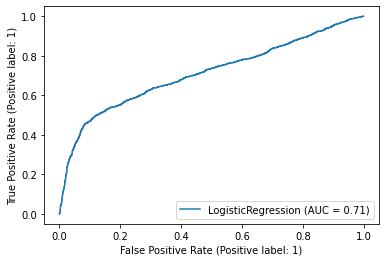

In [ ]:
from sklearn import metrics
y_pred_val_Lr_PCA = logisticRegr.predict_proba(Xtest_PCA)[:,1]
auc_roc = metrics.roc_auc_score(y_test, y_pred_val_Lr_PCA)
print('AUC =', auc_roc)

metrics.plot_roc_curve(logisticRegr, Xtest_PCA, y_test)
plt.show()    

In [ ]:
y_pred_RL =logisticRegr.predict(Xtest_PCA)

In [ ]:
confusion_matrix(y_test, y_pred_RL)

array([[4500,  126],
       [1034,  340]], dtype=int64)

In [ ]:
print("Reporte de Clasificación:\n",
      classification_report( y_test, y_pred_RL))

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.81      0.97      0.89      4626
           1       0.73      0.25      0.37      1374

    accuracy                           0.81      6000
   macro avg       0.77      0.61      0.63      6000
weighted avg       0.79      0.81      0.77      6000



In [ ]:
Cs_p=[9,10,11]
solver_p=['lbfgs']

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold, cross_validate
skf = StratifiedKFold(n_splits = 10)
Rgl_CV = LogisticRegressionCV(penalty = 'l2', 
                                Cs = Cs_p,
                                cv = skf,
                                random_state = 0, 
                                max_iter = 1000, 
                                verbose = 1,
                                solver = 'lbfgs',
                                n_jobs = 8,
                                    )

In [ ]:
Rgl_CV.fit(Xtrain_PCA, y_train)
#Rgl_CV.fit(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.2s finished


LogisticRegressionCV(Cs=[9, 10, 11],
                     cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                     max_iter=1000, n_jobs=8, random_state=0, verbose=1)

In [ ]:
score_train_Lrg_CV= Rgl_CV.score(Xtrain_PCA, y_train)
score_test_Lrg_CV = Rgl_CV.score(Xtest_PCA, y_test)
print('Exactitud en el conjunto de entrenamiento: %0.4f' % score_train_Lrg_CV)
print('Exactitud en el conjunto de validación: %0.4f' % score_test_Lrg_CV)

Exactitud en el conjunto de entrenamiento: 0.8104
Exactitud en el conjunto de validación: 0.8067


AUC = 0.7099543684169786


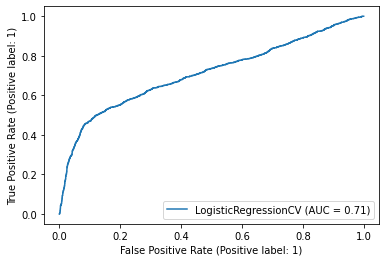

In [ ]:
y_pred_val_Rgl = Rgl_CV.predict_proba(Xtest_PCA)[:,1]
auc_roc = metrics.roc_auc_score(y_test, y_pred_val_Rgl)
print('AUC =', auc_roc)

metrics.plot_roc_curve(Rgl_CV, Xtest_PCA, y_test)
plt.show()    

#### Mejor predicción en los que incumpliran el pago (DEFAULT=1)

##### Aplicando penalidad por desbalanceo de clases

Si lo que se deseara es obtener una mejor predicción en los que incumpliran el pago (`DEFAULT`=1), teniendo en cuenta a que esta es la clase minoritaria y que existe un desbalance de clase se debe hacer un balanceo de clase.
Se utiliza el parametro `class_weight` para tratar de balancear las clases

In [ ]:
logisticRegr_P = LogisticRegression (C=1.0,penalty='l2',random_state=1,
                                   solver="lbfgs",class_weight="balanced")

In [ ]:
logisticRegr_P.fit (Xtrain_PCA, y_train)

LogisticRegression(class_weight='balanced', random_state=1)

In [ ]:
score_train_Lr_P = logisticRegr_P.score(Xtrain_PCA, y_train)
score_test_Lr_P = logisticRegr_P.score(Xtest_PCA, y_test)
print('Exactitud en el conjunto de entrenamiento: %0.4f' % score_train_Lr_P)
print('Exactitud en el conjunto de validación: %0.4f' % score_test_Lr_P)

Exactitud en el conjunto de entrenamiento: 0.6915
Exactitud en el conjunto de validación: 0.6863


AUC = 0.7108774152297846


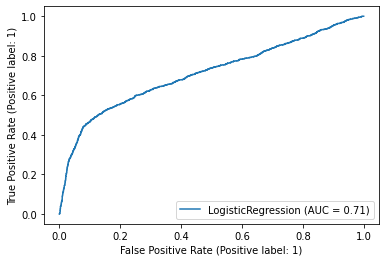

In [ ]:
from sklearn import metrics
y_pred_val_Lr_P= logisticRegr_P.predict_proba(Xtest_PCA)[:,1]
auc_roc = metrics.roc_auc_score(y_test, y_pred_val_Lr_P)
print('AUC =', auc_roc)

metrics.plot_roc_curve(logisticRegr_P, Xtest_PCA, y_test)
plt.show()    

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [ ]:
y_pred_RL_p =logisticRegr_P.predict(Xtest_PCA)

In [ ]:
confusion_matrix(y_test, y_pred_RL_p)

array([[3264, 1362],
       [ 520,  854]], dtype=int64)

In [ ]:
print("Reporte de Clasificación:\n",
      classification_report( y_test, y_pred_RL_p))

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.86      0.71      0.78      4626
           1       0.39      0.62      0.48      1374

    accuracy                           0.69      6000
   macro avg       0.62      0.66      0.63      6000
weighted avg       0.75      0.69      0.71      6000



Se puede observar que en comparación con el reporte de clasificación anterior el la medida de recall en la clase 1 aumento de 0.25 a 0.62 por lo cual se muestra una gran mejora para el objetivo de obtener una mejor predicción en los que incumpliran el pago.

## Conclusión

El mejor clasificador se obtuvo usando el modelo Random Forest con un valor de ROC de 0.78. 
Por otro lado, si el objetivo estaria enfocado hacia una mejor predicción en los que incumpliran el pago 